1. Calculer les 6 points à l'infini
   1. Trouver intersections avec `findChessboardCorner` de openCV -> trouver les points intérieurs
   2. Raffiner avec `refineCorner` pour être sous pixelique
   3. Calculer droite de régression pour chaque ligne
   4. Point à l'infini : centroide des intersections de lignes 

In [170]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from copy import deepcopy

import matplotlib.image

In [32]:

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
fname = "view1.jpg"

img = cv.imread(fname)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

IMG_HEIGHT,IMG_WIDTH = img.shape[:2]

# Find the chess board corners
ret, corners = cv.findChessboardCorners(gray, (9,7))

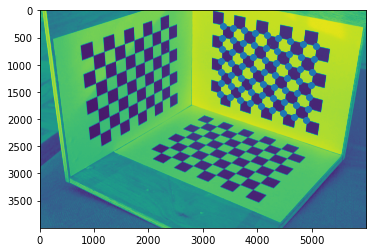

In [39]:
plt.imshow(gray)

# plt.scatter(
#     IMG_WIDTH - corners.reshape((2,7*9))[1,:],
#     IMG_HEIGHT - corners.reshape((2,7*9))[0,:]
# )

plt.scatter(
    corners.reshape((7*9,2))[:,0],
    corners.reshape((7*9,2))[:,1]
)

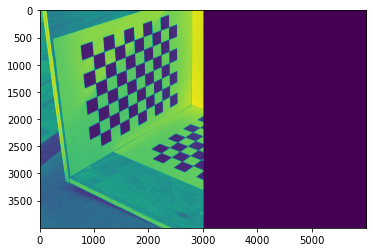

In [92]:
img1 = deepcopy(gray)
img1[:,IMG_WIDTH//2:] = 0

img2 = deepcopy(gray)
img2[:,:IMG_WIDTH//2] = 0

img3 = deepcopy(gray)
img3[:IMG_HEIGHT//3,:] = 0

sub_images = {
    "upper_left" : img1,
    "upper_right" : img2,
    "lower" : img3
}

plt.imshow(img1)

In [50]:
imgs = [img1,img2,img3]
corners_list = []
for img in imgs :
    ret,corners = cv.findChessboardCorners(img, (9,7))
    if ret : 
        corners_list.append(corners.reshape((7*9,2)))
    else :
        print("Corners not found")

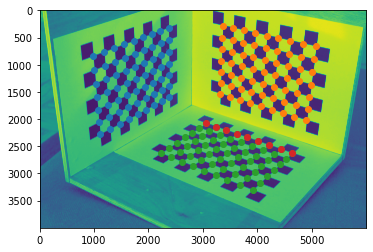

In [55]:
plt.imshow(gray)
for corners in corners_list:
    plt.scatter(corners[:,0],corners[:,1])
    
plt.scatter(corners[:9,0],corners[:9,1])
    

In [52]:
from scipy.stats import linregress

In [99]:
# droites de régression

lines_hori_list = []
lines_vert_list = []

for corners in corners_list:

    # horizontal lines
    lines_hori = []
    for i in range(7):
        data = corners[i*9:(i+1)*9,:]
        # plt.plot(data[:,0],data[:,1])
        line = linregress(data[:,0],data[:,1])
        lines_hori.append(line)
        
    lines_hori_list.append(lines_hori)
        
    # vertical lines
    lines_vert = []
    for i in range(9):
        data = corners[i::9,:]
        # plt.plot(data[:,0],data[:,1])
        line = linregress(data[:,0],data[:,1])
        lines_vert.append(line) 
        
    lines_vert_list.append(lines_vert)

In [100]:
# compute intersections

def intersect(l1,l2):
    m1,b1 = l1.slope, l1.intercept    
    m2,b2 = l2.slope, l2.intercept
    x = (b2-b1)/(m1-m2)
    y = m1*x + b1 
    return np.array((x,y))

In [101]:
# compute intersections

points_hori_list = [np.zeros((21,2))]*3
points_vert_list = [np.zeros((36,2))]*3

for n in range(3):
    
    lines_hori = lines_hori_list[n]
    lines_vert = lines_vert_list[n]
    
    k = 0
    for i in range(7):
        for j in range(i+1,7):
            
            l1,l2 = lines_hori[i],lines_hori[j]
            points_hori_list[n][k,:] = intersect(l1,l2)
            k += 1
        
    k = 0
    for i in range(9):
        for j in range(i+1,9):
            
            l1,l2 = lines_vert[i],lines_vert[j]
            points_vert_list[n][k,:] = intersect(l1,l2)
            k += 1
        

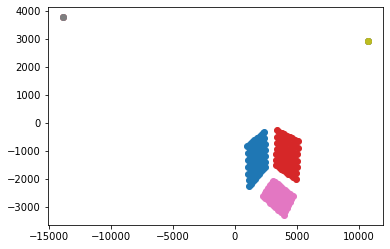

In [105]:
# plot it 
for n in range(3):
    
    corners = corners_list[n]
    
    points_hori = points_hori_list[n]
    points_vert = points_vert_list[n]
    
    point_hori_inf = points_hori.mean(axis=0)
    point_vert_inf = points_vert.mean(axis=0)
    
    plt.scatter(corners[:,0],-corners[:,1])
    plt.scatter(point_hori_inf[0],-point_hori_inf[1])
    plt.scatter(point_vert_inf[0],-point_vert_inf[1])


In [112]:
# assemble everything

points_inf = {}

for name,img in sub_images.items():
    
    # extract corners
    ret,corners = cv.findChessboardCorners(img, (9,7))
    corners = corners.reshape((7*9,2))
    
    if not(ret):
        raise Exception(f"Corners not found in image {name}")
    
    # compute linear regressions
    # horizontal lines
    lines_hori = []
    for i in range(7):
        data = corners[i*9:(i+1)*9,:]
        # plt.plot(data[:,0],data[:,1])
        line = linregress(data[:,0],data[:,1])
        lines_hori.append(line)
        
    # vertical lines
    lines_vert = []
    for i in range(9):
        data = corners[i::9,:]
        # plt.plot(data[:,0],data[:,1])
        line = linregress(data[:,0],data[:,1])
        lines_vert.append(line) 
        
    # compute intersection points
    points_hori = np.zeros((21,2))
    k = 0
    for i in range(7):
        for j in range(i+1,7):
            l1,l2 = lines_hori[i],lines_hori[j]
            points_hori[k,:] = intersect(l1,l2)
            k += 1

    points_vert = np.zeros((36,2))
    k = 0
    for i in range(9):
        for j in range(i+1,9):
            l1,l2 = lines_vert[i],lines_vert[j]
            points_vert[k,:] = intersect(l1,l2)
            k += 1
            
    # compute barycenters
    point_inf_hori = points_hori.mean(axis=0)
    point_inf_vert = points_vert.mean(axis=0)
    
    points_inf[name] = np.array([point_inf_hori, point_inf_vert])

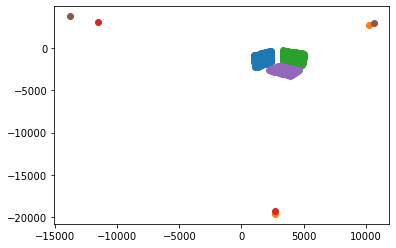

In [114]:
for corners,point_inf in zip(corners_list,points_inf.values()):

    plt.scatter(corners[:,0],-corners[:,1])
    plt.scatter(point_inf[:,0],-point_inf[:,1])


In [141]:
# methode cross product

points_inf = {}

for name,img in sub_images.items():
    
    # extract corners
    ret,corners = cv.findChessboardCorners(img, (9,7))
    corners = corners.reshape((7*9,2))
    
    if not(ret):
        raise Exception(f"Corners not found in image {name}")
    
    # compute linear regressions
    # horizontal lines
    lines_hori = []
    for i in range(7):
        data = corners[i*9:(i+1)*9,:]

        reglin = linregress(data[:,0],data[:,1])
        m,b = reglin.slope, reglin.intercept
        
        x0,x1 = data[0,0],data[-1,0]
        y0,y1 = b + x0*m, b+x1*m
        
        line = np.cross(
            np.array([x0,y0,1]), np.array([x1,y1,1])
        )
        
        lines_hori.append(line)
        
    # vertical lines
    lines_vert = []
    for i in range(9):
        data = corners[i::9,:]
        
        reglin = linregress(data[:,0],data[:,1])
        m,b = reglin.slope, reglin.intercept
        
        x0,x1 = data[0,0],data[-1,0]
        y0,y1 = b + x0*m, b+x1*m
        
        line = np.cross(
            np.array([x0,y0,1]), np.array([x1,y1,1])
        )
        
        lines_vert.append(line)
        
    # compute intersection points
    points_hori = np.zeros((21,3))

    k = 0 
    for i in range(7):
        for j in range(i+1,7):
            
            l1,l2 = lines_hori[i],lines_hori[j]
            points_hori[k,:] = np.cross(l1,l2)
            points_hori[k,:] /= points_hori[k,2]
            k += 1

    points_vert = np.zeros((36,3))
    k = 0
    for i in range(9):
        for j in range(i+1,9):
            l1,l2 = lines_vert[i],lines_vert[j]
            points_vert[k,:] = np.cross(l1,l2)
            points_vert[k,:] /= points_vert[k,2]
            k += 1
            
    # compute barycenters
    point_inf_hori = points_hori.mean(axis=0)
    point_inf_vert = points_vert.mean(axis=0)
    
    points_inf[name] = np.array([point_inf_hori, point_inf_vert])

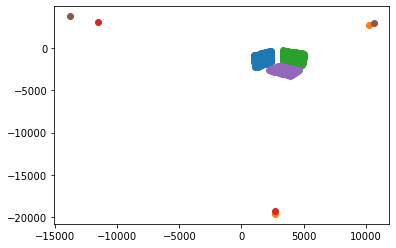

In [142]:
for corners,point_inf in zip(corners_list,points_inf.values()):
    plt.scatter(corners[:,0],-corners[:,1])
    plt.scatter(point_inf[:,0],-point_inf[:,1])
    
plt.show()

In [166]:
point_inf = points_inf['upper_right']
# point_inf = points_inf['lower']
line_inf = np.cross(point_inf[0,:],point_inf[1,:])
line_inf /= line_inf[2]

H = np.array([
    [1, 0, 0],
    [0, 1, 0],
    line_inf
])

In [167]:
img1_redressed = cv.warpPerspective(gray, H, (IMG_WIDTH, IMG_HEIGHT) )

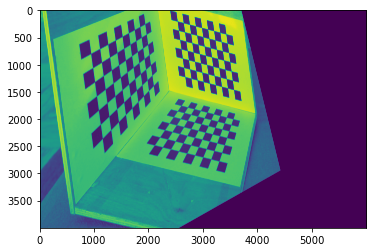

In [169]:
plt.imshow(img1_redressed)


<Figure size 432x288 with 0 Axes>

In [163]:
# check bounds after transform
print(H@np.array([IMG_WIDTH,0,1]))
print(H@np.array([0,IMG_HEIGHT,1]))

[6.00000000e+03 0.00000000e+00 3.60415341e-01]
[0.00000000e+00 4.00000000e+03 8.54153848e-01]


In [ ]:
img_parallel_x = np.zeros([IMG_HEIGHT,IMG_WIDTH])
img_parallel_y = np.zeros([IMG_HEIGHT,IMG_WIDTH])

for i in tqdm(range(IMG_HEIGHT)):
    for y in range(IMG_WIDTH):
        
        x,y,_ = homo_matrix @ np.array([i,j,1])
        
        img_parallel_x[i,j] = x        
        img_parallel_y[i,j] = y

100%|██████████| 4000/4000 [01:27<00:00, 45.61it/s]


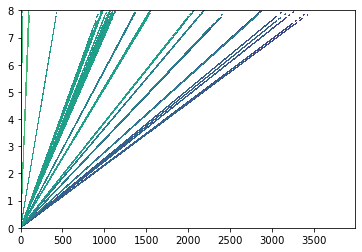

In [ ]:
# interpolation : cv2.warpPerspective

plt.contourf(img_parallel_x, img_parallel_y, gray)